In [1]:
!cd /kaggle/working/
!rm -rf *

In [2]:
!pip install split-folders

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, models, transforms
import os
import shutil
import time
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, ConcatDataset
from PIL import Image
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import copy
import splitfolders

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
input_path = "/kaggle/input/realwaste/realwaste-main/RealWaste"

working_path = "/kaggle/working/realwaste"

shutil.copytree(input_path, working_path, dirs_exist_ok=True)

print("Dataset copied successfully to working directory!")

Dataset copied successfully to working directory!


In [6]:
base_dir = "/kaggle/working/realwaste"
for folder in os.listdir(base_dir):
    count = len(os.listdir(os.path.join(base_dir, folder)))
    print(f"{folder}: {count} images")

Vegetation: 436 images
Metal: 790 images
Cardboard: 461 images
Textile Trash: 318 images
Food Organics: 411 images
Plastic: 921 images
Glass: 420 images
Miscellaneous Trash: 495 images
Paper: 500 images


In [7]:
# Configuration
IMG_SIZE = (224, 224)
DATA_DIR = "/kaggle/input/realwaste/realwaste-main/RealWaste"

In [8]:
input_folder = base_dir
split_dir = "/kaggle/working/RealWaste_split"

splitfolders.ratio(input_folder, output=split_dir, seed=42, ratio=(.7, .15, .15))

Copying files: 4752 files [00:01, 4432.23 files/s]


In [9]:
# Count images in each subfolder
for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dir, split)
    print(f"\n{split.upper()} SET")
    total = 0
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        count = len(os.listdir(cls_path))

        total += count
        print(f"  {cls}: {count} images")
    print(f" Total {split}: {total} images")


TRAIN SET
  Vegetation: 305 images
  Metal: 553 images
  Cardboard: 322 images
  Textile Trash: 222 images
  Food Organics: 287 images
  Plastic: 644 images
  Glass: 294 images
  Miscellaneous Trash: 346 images
  Paper: 350 images
 Total train: 3323 images

VAL SET
  Vegetation: 65 images
  Metal: 118 images
  Cardboard: 69 images
  Textile Trash: 47 images
  Food Organics: 61 images
  Plastic: 138 images
  Glass: 63 images
  Miscellaneous Trash: 74 images
  Paper: 75 images
 Total val: 710 images

TEST SET
  Vegetation: 66 images
  Metal: 119 images
  Cardboard: 70 images
  Textile Trash: 49 images
  Food Organics: 63 images
  Plastic: 139 images
  Glass: 63 images
  Miscellaneous Trash: 75 images
  Paper: 75 images
 Total test: 719 images


In [10]:
# Data Augmentation
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomResizedCrop(size=IMG_SIZE[0], scale=(0.6, 0.9)),
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor()
])

val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder("/kaggle/working/RealWaste_split/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("/kaggle/working/RealWaste_split/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder("/kaggle/working/RealWaste_split/test", transform=val_test_transforms)

# Get number of classes and device
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 9


In [11]:
# Increase the number of training data
duplication_factor = 3
train_dataset_augmented = ConcatDataset([train_dataset] * duplication_factor)

In [12]:
# Extract targets
targets = []
for dataset in train_dataset_augmented.datasets:  # train_dataset_augmented.datasets is a list
    if hasattr(dataset, 'targets'):
        targets.extend(dataset.targets)
    else:
        # fallback if custom dataset
        for i in range(len(dataset)):
            _, label = dataset[i]
            targets.append(label)

# Convert to numpy
targets = np.array(targets)

# Class counts
class_counts = np.bincount(targets)
print("Class counts:", class_counts)

base_dataset = train_dataset_augmented.datasets[0]  # first dataset in the concat list
classes = base_dataset.classes

# Compute class weights (inverse of frequency)
class_weights = 1. / class_counts

# Ensure sample_weights are floats for the sampler
sample_weights = [class_weights[label].item() for label in targets]

print("Class counts per category:")
for cls, count in zip(classes, class_counts):
    print(f"  {cls:15s}: {count}")

print("\n Class weights (inverse of frequency):")
for cls, w in zip(classes, class_weights):
    print(f"  {cls:15s}: {w:.6f}")

Class counts: [ 966  861  882 1659 1038 1050 1932  666  915]
Class counts per category:
  Cardboard      : 966
  Food Organics  : 861
  Glass          : 882
  Metal          : 1659
  Miscellaneous Trash: 1038
  Paper          : 1050
  Plastic        : 1932
  Textile Trash  : 666
  Vegetation     : 915

 Class weights (inverse of frequency):
  Cardboard      : 0.001035
  Food Organics  : 0.001161
  Glass          : 0.001134
  Metal          : 0.000603
  Miscellaneous Trash: 0.000963
  Paper          : 0.000952
  Plastic        : 0.000518
  Textile Trash  : 0.001502
  Vegetation     : 0.001093


In [13]:
# Define a consistent BATCH_SIZE
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


print(f"\n WeightedRandomSampler created successfully!")
print(f" Total samples in epoch: {len(sample_weights)}")
print(f" Training Batch size: {train_loader.batch_size}")
print(f" Validation Batch size: {val_loader.batch_size}")
print(f" Total training batches per epoch: {len(train_loader)}")


 WeightedRandomSampler created successfully!
 Total samples in epoch: 9969
 Training Batch size: 32
 Validation Batch size: 32
 Total training batches per epoch: 312


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0
    
        # TRAINING LOOP
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item() * images.size(0)
    
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_acc = 100 * correct / total
            train_loop.set_postfix(loss=loss.item(), acc=train_acc)
    
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # VALIDATION LOOP
        model.eval()
        val_running_loss = 0
        val_correct = 0
        val_total = 0
    
        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)", leave=False)
            for images, labels in val_loop:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                val_running_loss += loss.item() * images.size(0)
    
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Summary
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [15]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()

        # Convolution Blocks
        self.conv_block1 = self._create_conv_block(3, 64)  # 64 filters
        self.conv_block2 = self._create_conv_block(64, 128)  # 128 filters
        self.conv_block3 = self._create_conv_block(128, 256)  # 256 filters
        self.conv_block4 = self._create_conv_block(256, 512)  # 512 filters
        self.conv_block5 = self._create_conv_block(512, 512)  # 512 filters
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.3)

    def _create_conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = CNNModel(num_classes=num_classes)
model_name = "Custom CNN"

# Loss Function
weights = torch.tensor(class_weights.copy(), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

model = model.to(device)

results = {}

def reset_weights(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [16]:
print(f"\n===== Training with Adam =====\n")

reset_weights(model)

# Adams Optimizer 
learning_rate = 2e-5
weight_decay = 1e-4
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)

# Scheduler of learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
results['Adam'] = (train_losses, val_losses, train_accuracies, val_accuracies)

model_save_path = f"/kaggle/working/trained_{model_name}_adam.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


===== Training with Adam =====



Epoch 1/20: Train Loss: 1.3738, Train Acc: 51.30% | Val Loss: 1.1125, Val Acc: 62.25%


Epoch 2/20: Train Loss: 0.9985, Train Acc: 64.20% | Val Loss: 1.0050, Val Acc: 63.24%


Epoch 3/20: Train Loss: 0.8452, Train Acc: 69.41% | Val Loss: 0.8902, Val Acc: 68.45%


Epoch 4/20: Train Loss: 0.7583, Train Acc: 72.17% | Val Loss: 0.8241, Val Acc: 70.99%


Epoch 5/20: Train Loss: 0.6834, Train Acc: 75.07% | Val Loss: 0.7480, Val Acc: 72.68%


Epoch 6/20: Train Loss: 0.6143, Train Acc: 77.37% | Val Loss: 0.7488, Val Acc: 74.79%


Epoch 7/20: Train Loss: 0.5778, Train Acc: 78.61% | Val Loss: 0.6386, Val Acc: 76.06%


Epoch 8/20: Train Loss: 0.5048, Train Acc: 81.10% | Val Loss: 0.6769, Val Acc: 74.51%


Epoch 9/20: Train Loss: 0.4893, Train Acc: 81.24% | Val Loss: 0.6451, Val Acc: 77.75%


Epoch 10/20: Train Loss: 0.4491, Train Acc: 83.47% | Val Loss: 0.5816, Val Acc: 78.73%


Epoch 11/20: Train Loss: 0.4245, Train Acc: 84.41% | Val Loss: 0.5046, Val Acc: 80.42%


Epoch 12/20: Train Loss: 0.3864, Train Acc: 85.19% | Val Loss: 0.5515, Val Acc: 78.17%


Epoch 13/20: Train Loss: 0.3804, Train Acc: 85.79% | Val Loss: 0.5305, Val Acc: 80.14%


Epoch 14/20: Train Loss: 0.3608, Train Acc: 86.32% | Val Loss: 0.5607, Val Acc: 80.70%


Epoch 15/20: Train Loss: 0.3204, Train Acc: 88.05% | Val Loss: 0.5274, Val Acc: 82.82%


Epoch 16/20: Train Loss: 0.3157, Train Acc: 88.26% | Val Loss: 0.5339, Val Acc: 82.39%


Epoch 17/20: Train Loss: 0.2862, Train Acc: 89.16% | Val Loss: 0.4619, Val Acc: 82.39%


Epoch 18/20: Train Loss: 0.2733, Train Acc: 89.50% | Val Loss: 0.5257, Val Acc: 80.70%


Epoch 19/20: Train Loss: 0.2577, Train Acc: 89.92% | Val Loss: 0.5417, Val Acc: 79.44%


Epoch 20/20: Train Loss: 0.2631, Train Acc: 89.97% | Val Loss: 0.4826, Val Acc: 83.52%
Model saved to /kaggle/working/trained_Custom CNN_adam.pth


In [17]:
print(f"\n===== Training with SGD =====\n")

reset_weights(model)

# SGD Optimizer 
learning_rate = 2e-4
weight_decay = 1e-4
optimizer = optim.SGD(
    model.parameters(), 
    lr= learning_rate, 
    weight_decay= weight_decay
)

# Scheduler of learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
results['SGD'] = (train_losses, val_losses, train_accuracies, val_accuracies)

model_save_path = f"/kaggle/working/trained_{model_name}_sgd.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


===== Training with SGD =====



Epoch 1/20: Train Loss: 2.0909, Train Acc: 24.38% | Val Loss: 1.9531, Val Acc: 50.00%


Epoch 2/20: Train Loss: 1.8430, Train Acc: 55.74% | Val Loss: 1.7395, Val Acc: 69.58%


Epoch 3/20: Train Loss: 1.6265, Train Acc: 68.24% | Val Loss: 1.5475, Val Acc: 73.10%


Epoch 4/20: Train Loss: 1.4347, Train Acc: 74.44% | Val Loss: 1.4083, Val Acc: 72.68%


Epoch 5/20: Train Loss: 1.2733, Train Acc: 77.13% | Val Loss: 1.2465, Val Acc: 76.76%


Epoch 6/20: Train Loss: 1.1372, Train Acc: 79.77% | Val Loss: 1.1390, Val Acc: 76.20%


Epoch 7/20: Train Loss: 1.0217, Train Acc: 81.80% | Val Loss: 1.0357, Val Acc: 80.28%


Epoch 8/20: Train Loss: 0.9169, Train Acc: 83.95% | Val Loss: 0.9572, Val Acc: 79.72%


Epoch 9/20: Train Loss: 0.8332, Train Acc: 85.30% | Val Loss: 0.8909, Val Acc: 79.01%


Epoch 10/20: Train Loss: 0.7625, Train Acc: 86.44% | Val Loss: 0.8075, Val Acc: 82.54%


Epoch 11/20: Train Loss: 0.7036, Train Acc: 87.10% | Val Loss: 0.7698, Val Acc: 81.41%


Epoch 12/20: Train Loss: 0.6481, Train Acc: 88.01% | Val Loss: 0.7244, Val Acc: 83.38%


Epoch 13/20: Train Loss: 0.6033, Train Acc: 89.02% | Val Loss: 0.6863, Val Acc: 83.24%


Epoch 14/20: Train Loss: 0.5673, Train Acc: 88.99% | Val Loss: 0.6585, Val Acc: 81.83%


Epoch 15/20: Train Loss: 0.5326, Train Acc: 89.68% | Val Loss: 0.6283, Val Acc: 84.37%


Epoch 16/20: Train Loss: 0.5031, Train Acc: 89.74% | Val Loss: 0.6305, Val Acc: 82.54%


Epoch 17/20: Train Loss: 0.4765, Train Acc: 90.30% | Val Loss: 0.6105, Val Acc: 81.97%


Epoch 18/20: Train Loss: 0.4469, Train Acc: 91.25% | Val Loss: 0.5706, Val Acc: 84.23%


Epoch 19/20: Train Loss: 0.4223, Train Acc: 91.40% | Val Loss: 0.6033, Val Acc: 80.85%


Epoch 20/20: Train Loss: 0.4077, Train Acc: 91.47% | Val Loss: 0.6124, Val Acc: 80.85%
Model saved to /kaggle/working/trained_Custom CNN_sgd.pth


In [18]:
print(f"\n===== Training with SGD with Momentum =====\n")

reset_weights(model)

# SGD with Momentum Optimizer 
learning_rate = 1e-4
weight_decay = 1e-4
optimizer = optim.SGD(
    model.parameters(), 
    lr= learning_rate, 
    weight_decay= weight_decay,
    momentum=0.8
)

# Scheduler of learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 20

# Training the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Save the model
results['SGD with Momentum'] = (train_losses, val_losses, train_accuracies, val_accuracies)

model_save_path = f"/kaggle/working/trained_{model_name}_sgdmomentum.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


===== Training with SGD with Momentum =====



Epoch 1/20: Train Loss: 1.7627, Train Acc: 54.33% | Val Loss: 1.4550, Val Acc: 73.52%


Epoch 2/20: Train Loss: 1.1988, Train Acc: 78.36% | Val Loss: 1.0775, Val Acc: 77.32%


Epoch 3/20: Train Loss: 0.8845, Train Acc: 84.68% | Val Loss: 0.8889, Val Acc: 78.73%


Epoch 4/20: Train Loss: 0.6971, Train Acc: 87.33% | Val Loss: 0.7221, Val Acc: 81.83%


Epoch 5/20: Train Loss: 0.5759, Train Acc: 88.45% | Val Loss: 0.6853, Val Acc: 81.27%


Epoch 6/20: Train Loss: 0.4935, Train Acc: 89.58% | Val Loss: 0.6150, Val Acc: 83.80%


Epoch 7/20: Train Loss: 0.4351, Train Acc: 90.53% | Val Loss: 0.5430, Val Acc: 83.94%


Epoch 8/20: Train Loss: 0.3929, Train Acc: 91.36% | Val Loss: 0.5552, Val Acc: 82.39%


Epoch 9/20: Train Loss: 0.3562, Train Acc: 91.72% | Val Loss: 0.5987, Val Acc: 80.14%


Epoch 10/20: Train Loss: 0.3305, Train Acc: 91.92% | Val Loss: 0.4668, Val Acc: 85.49%


Epoch 11/20: Train Loss: 0.3044, Train Acc: 92.52% | Val Loss: 0.5965, Val Acc: 80.42%


Epoch 12/20: Train Loss: 0.2876, Train Acc: 92.73% | Val Loss: 0.5152, Val Acc: 81.55%


Epoch 13/20: Train Loss: 0.2716, Train Acc: 93.23% | Val Loss: 0.4676, Val Acc: 83.66%


Epoch 14/20: Train Loss: 0.2600, Train Acc: 93.03% | Val Loss: 0.6004, Val Acc: 78.31%


Epoch 15/20: Train Loss: 0.2428, Train Acc: 93.35% | Val Loss: 0.4359, Val Acc: 85.21%


Epoch 16/20: Train Loss: 0.2343, Train Acc: 93.89% | Val Loss: 0.4309, Val Acc: 85.35%


Epoch 17/20: Train Loss: 0.2268, Train Acc: 93.75% | Val Loss: 0.5252, Val Acc: 82.39%


Epoch 18/20: Train Loss: 0.2227, Train Acc: 93.86% | Val Loss: 0.4751, Val Acc: 82.25%


Epoch 19/20: Train Loss: 0.2100, Train Acc: 93.86% | Val Loss: 0.4499, Val Acc: 84.23%


Epoch 20/20: Train Loss: 0.2025, Train Acc: 94.42% | Val Loss: 0.4351, Val Acc: 83.66%
Model saved to /kaggle/working/trained_Custom CNN_sgdmomentum.pth


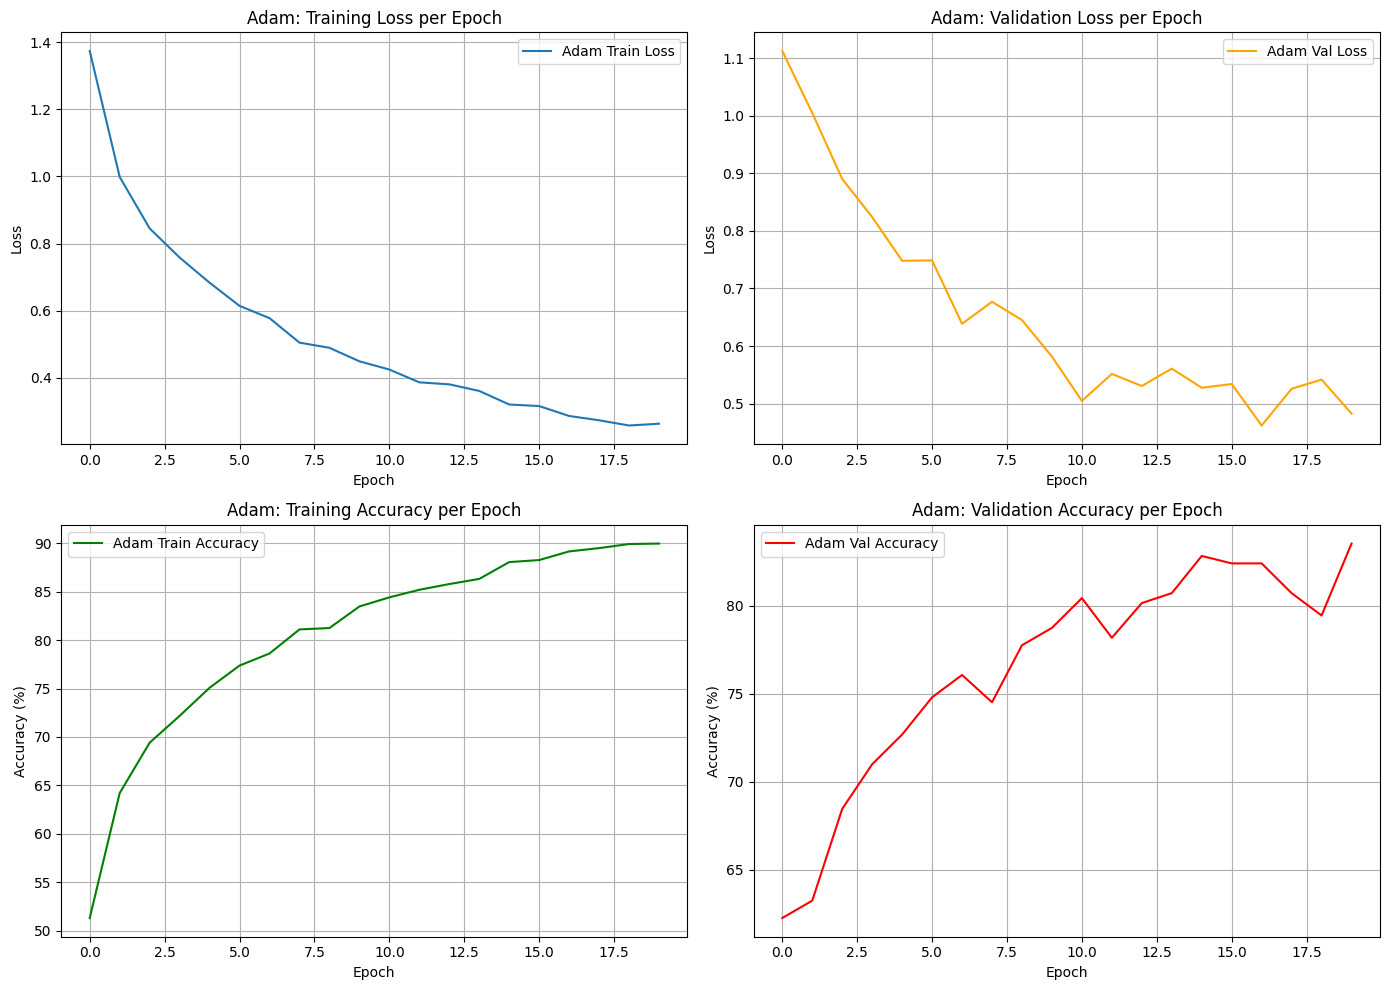

In [19]:
plt.figure(figsize=(14, 10))

# 1️⃣ Train Loss
plt.subplot(2, 2, 1)
plt.plot(results["Adam"][0], label="Adam Train Loss")
plt.title("Adam: Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 2️⃣ Validation Loss
plt.subplot(2, 2, 2)
plt.plot(results["Adam"][1], label="Adam Val Loss", color='orange')
plt.title("Adam: Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3️⃣ Training Accuracy
plt.subplot(2, 2, 3)
plt.plot(results["Adam"][2], label="Adam Train Accuracy", color='green')
plt.title("Adam: Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# 4️⃣ Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(results["Adam"][3], label="Adam Val Accuracy", color='red')
plt.title("Adam: Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


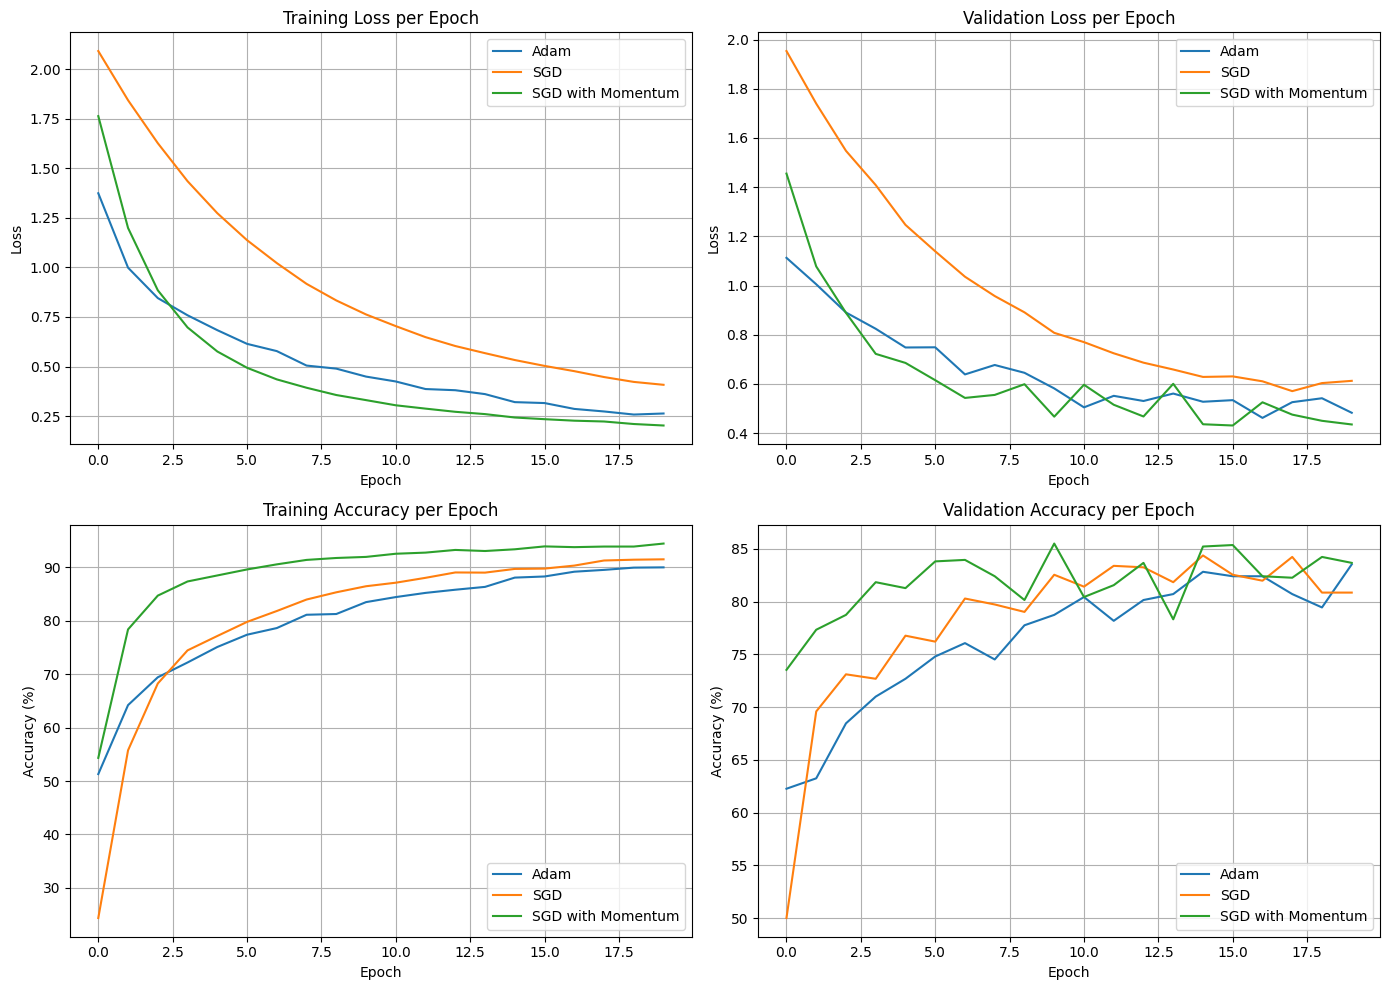

In [20]:
plt.figure(figsize=(14, 10))

# 1️ Train Loss
plt.subplot(2, 2, 1)
for name in results:
    plt.plot(results[name][0], label=f"{name}")
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 2️ Validation Loss
plt.subplot(2, 2, 2)
for name in results:
    plt.plot(results[name][1], label=f"{name}")
plt.title("Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3️ Training Accuracy
plt.subplot(2, 2, 3)
for name in results:
    plt.plot(results[name][2], label=f"{name}")
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# 4️ Validation Accuracy
plt.subplot(2, 2, 4)
for name in results:
    plt.plot(results[name][3], label=f"{name}")
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [21]:
print("\n===== Validation Accuracy Comparison =====\n")
for name in results:
    val_acc_list = results[name][3]   
    if len(val_acc_list) > 0:
        final_val_acc = val_acc_list[-1]  
        print(f"{name} Final Validation Accuracy: {final_val_acc:.2f}%")
    else:
        print(f"{name} has no validation records. (Check training loop)")

print("\n===== Best Validation Accuracy for Each Optimizer =====\n")
for name in results:
    val_acc_list = results[name][3]
    if len(val_acc_list) > 0:
        best_val_acc = max(val_acc_list)
        print(f"{name} Best Validation Accuracy: {best_val_acc:.2f}%")
    else:
        print(f"{name} has no validation records.")


===== Validation Accuracy Comparison =====

Adam Final Validation Accuracy: 83.52%
SGD Final Validation Accuracy: 80.85%
SGD with Momentum Final Validation Accuracy: 83.66%

===== Best Validation Accuracy for Each Optimizer =====

Adam Best Validation Accuracy: 83.52%
SGD Best Validation Accuracy: 84.37%
SGD with Momentum Best Validation Accuracy: 85.49%


In [22]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    return avg_test_loss, test_accuracy

In [23]:
model_paths = {
    "Adam": "/kaggle/working/trained_Custom CNN_adam.pth",
    "SGD": "/kaggle/working/trained_Custom CNN_sgd.pth",
    "SGD with Momentum": "/kaggle/working/trained_Custom CNN_sgdmomentum.pth"
}

print("\n===== Test Set Evaluation =====\n")

for name, path in model_paths.items():
    # Load fresh model architecture
    test_model = CNNModel(num_classes=9).to(device)
    test_model.load_state_dict(torch.load(path, map_location=device))

    test_loss, test_acc = evaluate_model(test_model, test_loader, criterion)

    print(f"{name} Optimizer -> Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")



===== Test Set Evaluation =====

Adam Optimizer -> Test Loss: 0.4877, Test Accuracy: 84.42%
SGD Optimizer -> Test Loss: 0.5943, Test Accuracy: 83.73%
SGD with Momentum Optimizer -> Test Loss: 0.4343, Test Accuracy: 86.09%


In [24]:
def evaluate_detailed(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()



===== Detailed Test Evaluation for Each Optimizer =====


--- Adam Optimizer ---


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.94      0.83      0.88        70
      Food Organics       0.91      0.94      0.92        63
              Glass       0.88      0.90      0.89        63
              Metal       0.76      0.92      0.83       119
Miscellaneous Trash       0.82      0.55      0.66        75
              Paper       0.87      0.83      0.85        75
            Plastic       0.80      0.88      0.84       139
      Textile Trash       0.82      0.67      0.74        49
         Vegetation       0.94      0.98      0.96        66

           accuracy                           0.84       719
          macro avg       0.86      0.83      0.84       719
       weighted avg       0.85      0.84      0.84       719



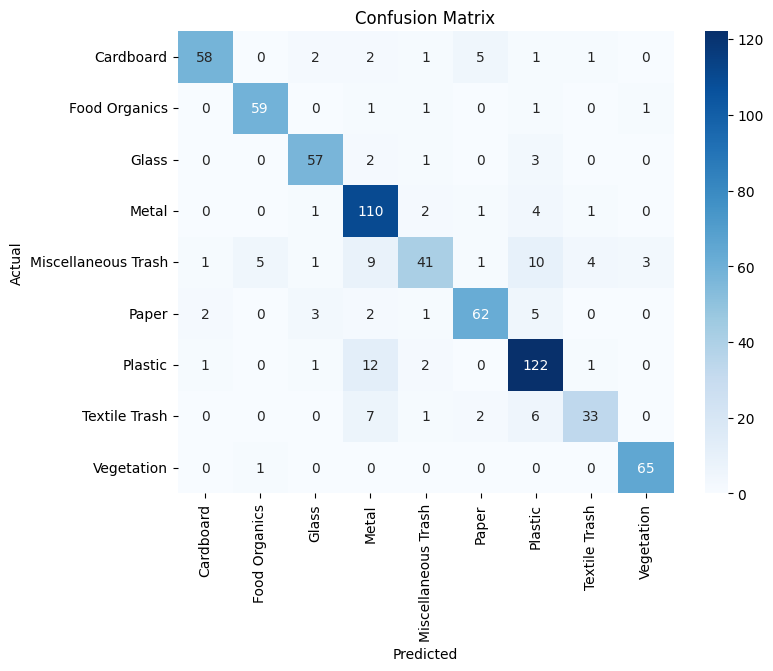


--- SGD Optimizer ---


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.90      0.94      0.92        70
      Food Organics       0.95      0.86      0.90        63
              Glass       0.94      0.79      0.86        63
              Metal       0.96      0.77      0.86       119
Miscellaneous Trash       0.66      0.68      0.67        75
              Paper       0.87      0.88      0.87        75
            Plastic       0.86      0.83      0.85       139
      Textile Trash       0.58      0.86      0.69        49
         Vegetation       0.81      0.98      0.89        66

           accuracy                           0.84       719
          macro avg       0.84      0.84      0.84       719
       weighted avg       0.85      0.84      0.84       719



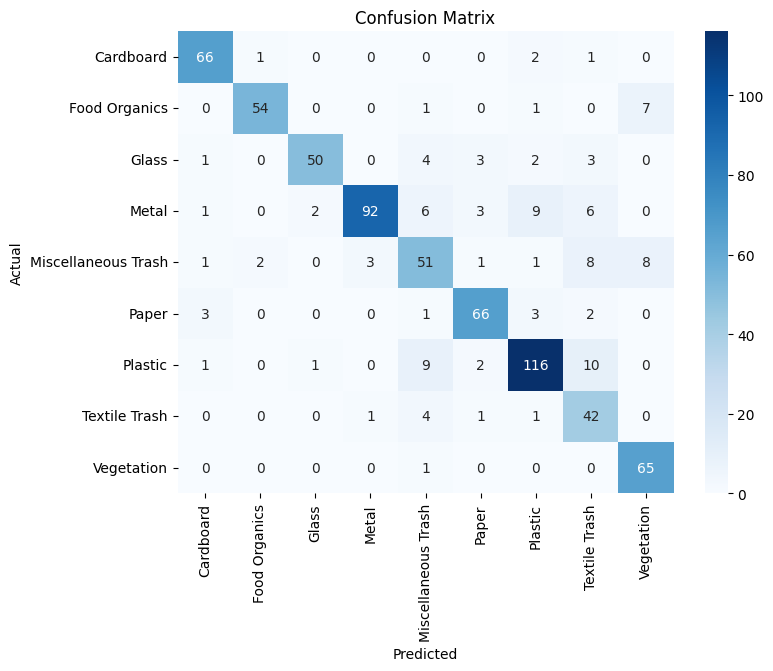


--- SGD with Momentum Optimizer ---


Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.96      0.91      0.93        70
      Food Organics       0.87      0.98      0.93        63
              Glass       0.88      0.94      0.91        63
              Metal       0.85      0.88      0.86       119
Miscellaneous Trash       0.68      0.69      0.68        75
              Paper       0.96      0.85      0.90        75
            Plastic       0.88      0.81      0.84       139
      Textile Trash       0.74      0.82      0.78        49
         Vegetation       0.95      0.91      0.93        66

           accuracy                           0.86       719
          macro avg       0.86      0.87      0.86       719
       weighted avg       0.86      0.86      0.86       719



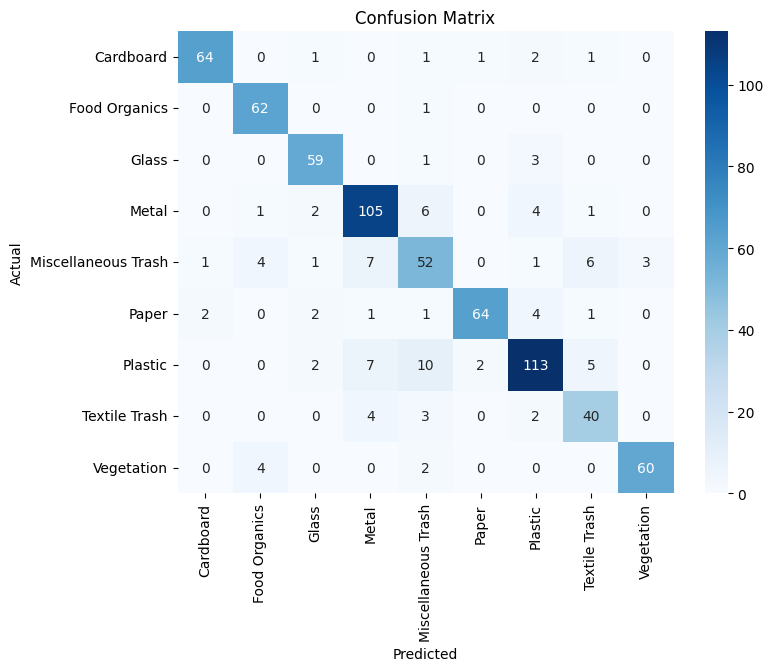

In [25]:
model_paths = {
    "Adam": "/kaggle/working/trained_Custom CNN_adam.pth",
    "SGD": "/kaggle/working/trained_Custom CNN_sgd.pth",
    "SGD with Momentum": "/kaggle/working/trained_Custom CNN_sgdmomentum.pth"
}

print("\n===== Detailed Test Evaluation for Each Optimizer =====\n")

for name, path in model_paths.items():
    print(f"\n--- {name} Optimizer ---\n")

    test_model = CNNModel(num_classes=9).to(device)
    test_model.load_state_dict(torch.load(path, map_location=device))

    evaluate_detailed(test_model, test_loader, classes)


Pre-trained Models

In [26]:
# Data Augmentation

data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(f"{split_dir}/{x}", data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

In [27]:
# Training Function (with Early Stopping)
def train_model_new(model, criterion, optimizer, scheduler, num_epochs, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stop_counter = 0

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print(f"\n========== Training {model.__class__.__name__} ==========\n")

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}\n" + "-"*30)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}, {phase.capitalize()} Acc: {epoch_acc:.4f}")

            # Early stopping based on validation accuracy
            if phase == "val":
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

        print()
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

In [28]:
# Model Definition Function

def get_model(model_name, num_classes, fine_tune=True, dropout_p=0.5):
    if model_name == "resnet":
        model = models.resnet18(pretrained=True)
        if not fine_tune:
            for param in model.parameters():
                param.requires_grad = False
        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )

    elif model_name == "vgg":
        model = models.vgg16(pretrained=True)
        if not fine_tune:
            for param in model.features.parameters():
                param.requires_grad = False
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, num_classes)
        )

    return model.to(device)

In [29]:
NUM_EPOCHS_COMP = 20 
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
num_classes = len(class_names)

# --- 1. ResNet-18 Transfer Learning ---

model_resnet = get_model("resnet", num_classes)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler_resnet = StepLR(optimizer_resnet, step_size=10, gamma=0.1)
model_resnet, resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc = train_model_new(
    model_resnet, criterion, optimizer_resnet, scheduler_resnet, num_epochs=NUM_EPOCHS_COMP
)

# --- 2. VGG-16 Transfer Learning ---

model_vgg = get_model("vgg", num_classes)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler_vgg = StepLR(optimizer_vgg, step_size=10, gamma=0.1)
model_vgg, vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc = train_model_new(
    model_vgg, criterion, optimizer_vgg, scheduler_vgg, num_epochs=NUM_EPOCHS_COMP
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]



========== Training ResNet ==========

Epoch 1/20
------------------------------
Train Loss: 1.3120, Train Acc: 0.5405
Val Loss: 0.9644, Val Acc: 0.6732

Epoch 2/20
------------------------------
Train Loss: 0.9546, Train Acc: 0.6627
Val Loss: 0.9064, Val Acc: 0.6535

Epoch 3/20
------------------------------
Train Loss: 0.8415, Train Acc: 0.7042
Val Loss: 0.7647, Val Acc: 0.7338

Epoch 4/20
------------------------------
Train Loss: 0.7742, Train Acc: 0.7237
Val Loss: 0.8795, Val Acc: 0.7014

Epoch 5/20
------------------------------
Train Loss: 0.7473, Train Acc: 0.7355
Val Loss: 0.7440, Val Acc: 0.7254

Epoch 6/20
------------------------------
Train Loss: 0.6238, Train Acc: 0.7830
Val Loss: 0.5606, Val Acc: 0.7972

Epoch 7/20
------------------------------
Train Loss: 0.6363, Train Acc: 0.7746
Val Loss: 0.5046, Val Acc: 0.8197

Epoch 8/20
------------------------------
Train Loss: 0.6089, Train Acc: 0.7909
Val Loss: 0.8779, Val Acc: 0.7521

Epoch 9/20
-----------------------------

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 200MB/s]



========== Training VGG ==========

Epoch 1/20
------------------------------
Train Loss: 1.6361, Train Acc: 0.3912
Val Loss: 1.0381, Val Acc: 0.6338

Epoch 2/20
------------------------------
Train Loss: 0.9713, Train Acc: 0.6494
Val Loss: 0.6153, Val Acc: 0.7915

Epoch 3/20
------------------------------
Train Loss: 0.7545, Train Acc: 0.7255
Val Loss: 0.5895, Val Acc: 0.7831

Epoch 4/20
------------------------------
Train Loss: 0.6385, Train Acc: 0.7779
Val Loss: 0.5029, Val Acc: 0.8225

Epoch 5/20
------------------------------
Train Loss: 0.5683, Train Acc: 0.8023
Val Loss: 0.4095, Val Acc: 0.8620

Epoch 6/20
------------------------------
Train Loss: 0.4912, Train Acc: 0.8357
Val Loss: 0.4173, Val Acc: 0.8606

Epoch 7/20
------------------------------
Train Loss: 0.4235, Train Acc: 0.8559
Val Loss: 0.4767, Val Acc: 0.8577

Epoch 8/20
------------------------------
Train Loss: 0.4004, Train Acc: 0.8619
Val Loss: 0.4081, Val Acc: 0.8746

Epoch 9/20
------------------------------
T

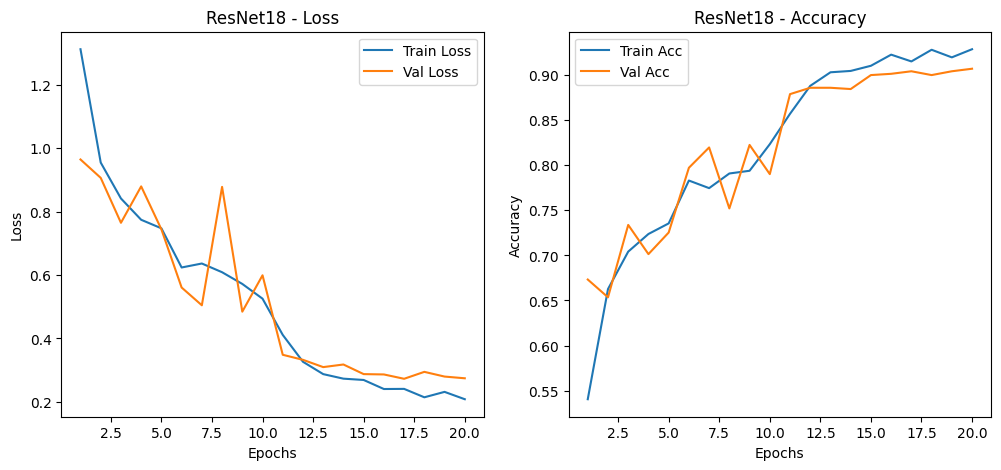

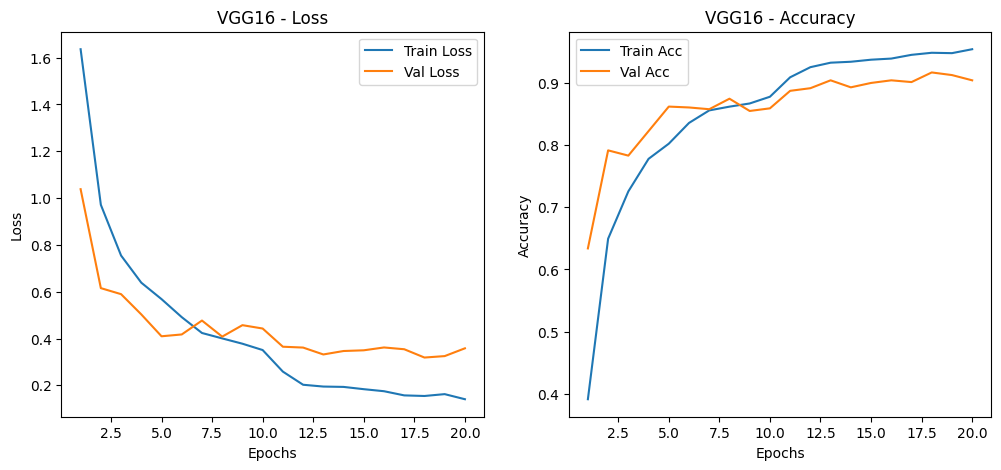

In [30]:
# Plotting Functions
def plot_metrics(train_loss, val_loss, train_acc, val_acc, title):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_metrics(resnet_train_loss, resnet_val_loss, resnet_train_acc, resnet_val_acc, "ResNet18")
plot_metrics(vgg_train_loss, vgg_val_loss, vgg_train_acc, vgg_val_acc, "VGG16")

In [31]:
# Test data transformations
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder('/kaggle/working/RealWaste_split/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

 Test Accuracy: 91.10%


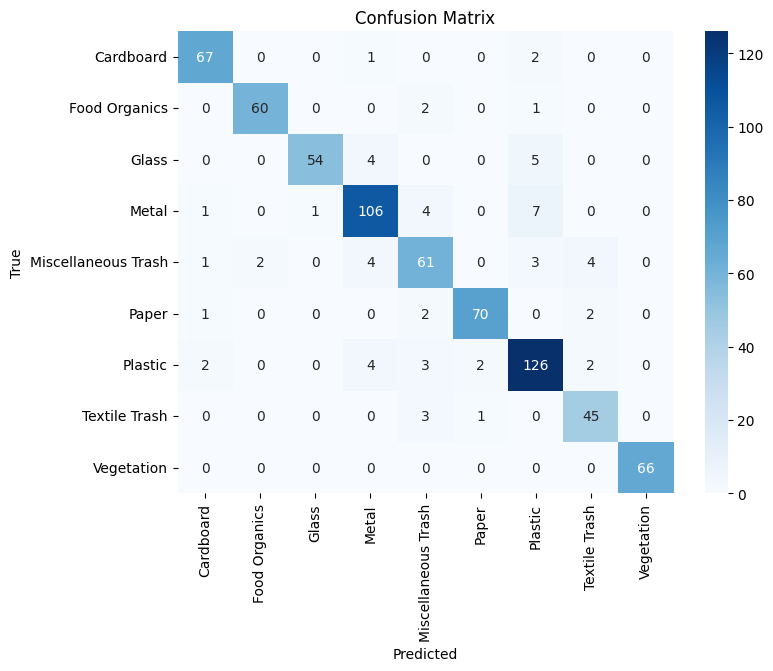


Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.93      0.96      0.94        70
      Food Organics       0.97      0.95      0.96        63
              Glass       0.98      0.86      0.92        63
              Metal       0.89      0.89      0.89       119
Miscellaneous Trash       0.81      0.81      0.81        75
              Paper       0.96      0.93      0.95        75
            Plastic       0.88      0.91      0.89       139
      Textile Trash       0.85      0.92      0.88        49
         Vegetation       1.00      1.00      1.00        66

           accuracy                           0.91       719
          macro avg       0.92      0.91      0.92       719
       weighted avg       0.91      0.91      0.91       719


 Overall Metrics:
Macro Precision: 0.9186
Macro Recall:    0.9143
Macro F1-Score:  0.9158
Weighted Precision: 0.9125
Weighted Recall:    0.9110
Weighted F1-Score:  0.9112


In [32]:
#For ResNet18
model_to_test = model_resnet  
model_to_test.eval()          
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_to_test(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f" Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

#  Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

#  Overall Metrics
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"\n Overall Metrics:")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")
print(f"Macro F1-Score:  {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall:    {recall_weighted:.4f}")
print(f"Weighted F1-Score:  {f1_weighted:.4f}")

 Test Accuracy: 89.57%


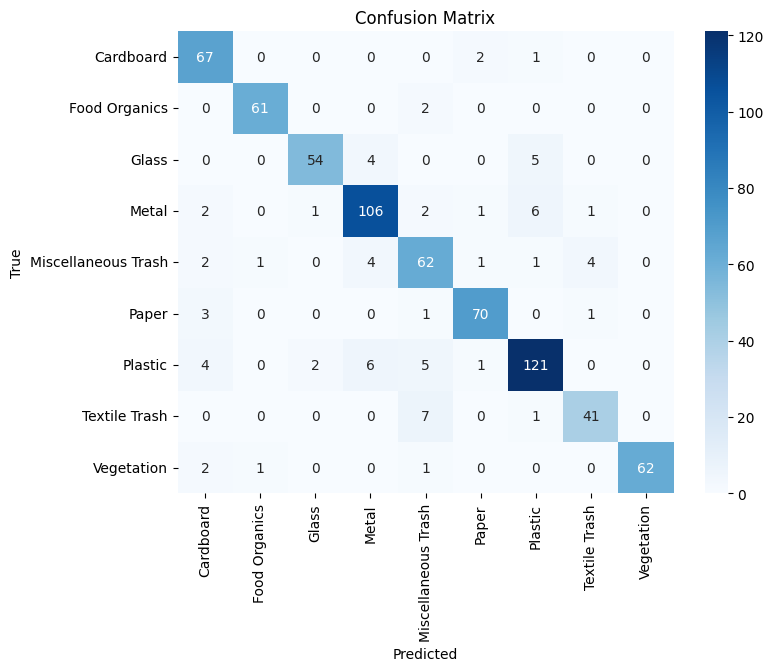


Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.84      0.96      0.89        70
      Food Organics       0.97      0.97      0.97        63
              Glass       0.95      0.86      0.90        63
              Metal       0.88      0.89      0.89       119
Miscellaneous Trash       0.78      0.83      0.80        75
              Paper       0.93      0.93      0.93        75
            Plastic       0.90      0.87      0.88       139
      Textile Trash       0.87      0.84      0.85        49
         Vegetation       1.00      0.94      0.97        66

           accuracy                           0.90       719
          macro avg       0.90      0.90      0.90       719
       weighted avg       0.90      0.90      0.90       719


 Overall Metrics:
Macro Precision: 0.9015
Macro Recall:    0.8978
Macro F1-Score:  0.8987
Weighted Precision: 0.8983
Weighted Recall:    0.8957
Weighted F1-Score:  0.8962


In [33]:
#For VGG16
model_to_test = model_vgg  
model_to_test.eval()          

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_to_test(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f" Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

#  Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#  Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

#  Overall Metrics
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

precision_weighted = precision_score(all_labels, all_preds, average='weighted')
recall_weighted = recall_score(all_labels, all_preds, average='weighted')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print(f"\n Overall Metrics:")
print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")
print(f"Macro F1-Score:  {f1_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall:    {recall_weighted:.4f}")
print(f"Weighted F1-Score:  {f1_weighted:.4f}")